In [1]:
!pip -q install numpy matplotlib torch

In [1]:
import math
import random
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
def make_linear_overlap(
        n_per_class = 1000, # 1,-1 클래스당 1000개의 점 해서 총 2000개 점
        mean = 2, # 양성 그룹은 (2,2)근처에, 음성 그룹은 (-2,-2)근처에 점 찍겠단거
        std = 2.5, #표준편차 : 점들이 중심에서 얼마나 넓게 퍼져있을지, 클수록 넓게 흩어짐
        angle_deg = 25.0, # 회전각도 : 음성그룹을 25도 회전시켜서 양성그룹이랑 살짝 겹치게 -> 더 어려운 문제
        flip_prob = 0.05, # 노이즈 비율 : 일부러 라벨을 틀리게 줘서 현실적인 데이터 주기
        device = "cpu",
        seed = 42
):
    g = torch.Generator(device=device).manual_seed(seed) # 랜덤 숫자 생성기

    pos = torch.randn((n_per_class,2),generator=g, device=device) * std + torch.tensor([mean,mean],device=device)
    # 양성 그룹 만들기 : (n_per_class,2) : 1000x2 행렬 
    # randn은 평균0, 표준편차 1인 정규분포에서 무작위 숫자 뽑기 
    # * std : 표준편차를 2.5로 늘리기 = 더 넓게 퍼뜨려 (std 디폴트 값 = 2.5) 
    # +torch.tensor([mean,mean]) 모든 점에 (2,2)를 더해서 중심을 (0,0)에서 (2,2)로 옮김
    neg = torch.randn((n_per_class,2),generator=g, device=device) * std + torch.tensor([-mean,-mean],device=device)

    theta = math.radians(angle_deg) # 컴퓨터가 쓰는 단위인 라디안으로
    R = torch.tensor([[math.cos(theta), -math.sin(theta)], # 회전행렬
                      [math.sin(theta), math.cos(theta)]], device = device)
    neg = neg@ R.T # 음성 그룹을 25도 회전시켜서 살짝 겹치게 

    X = torch.cat([pos,neg], dim=0) # 세로로 쌓기 pos랑 neg가 각각 1000x2인데 cat해서 2000x2되도록
    y = torch.cat([torch.ones(n_per_class, device=device),
                   -torch.ones(n_per_class, device=device)],dim=0) #라벨 만들기 : 앞1000개는 +1, 뒤1000개는 -1 : 전체는 (2000,)
    
    if(flip_prob) >0 : # flip_prob는 노이즈 비율, 디폴트는 0.05
        flip_mask = torch.rand(X.size(0), generator=g, device=device) < flip_prob # 2000개 점 각각에 대해 0과1 사이 랜덤한 숫자 생성, 0.05보다 작으면 True
        y = torch.where(flip_mask, -y, y) #flip_mask가 true면 -y, 라벨 뒤집으라는거(1이면 -1 이런식), 약 3%의 데이터가 틀린 값을 갖게 됨

    perm = torch.randperm(X.size(0), generator = g, device=device) # X.size(0)은 2000
    # 0부터 1999까지의 숫자를 무작위로 섞은 순서 만들기 
    X = X[perm]
    y = y[perm] # 위에서 만든 랜덤한 순서(permutation)으로 재배열 

    return X,y 

X,y = make_linear_overlap(
    n_per_class=1000,
    mean = 5, # 더 멀리 되도록
    std = 3.2,
    angle_deg = 25.0,
    flip_prob = 0.03
)

print(f"X's shape is {X.shape}\ny's shape is {y.shape}")



X's shape is torch.Size([2000, 2])
y's shape is torch.Size([2000])


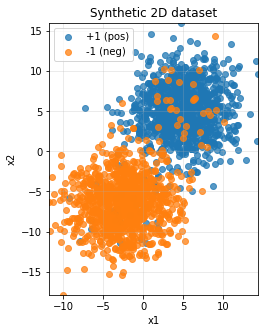

In [10]:
X_np = X.numpy()
y_np = y.numpy() 

plt.figure(figsize=(6,5))
plt.scatter(X_np[y_np==1, 0], X_np[y_np==1, 1], label="+1 (pos)", alpha = 0.75) 
plt.scatter(X_np[y_np==-1,0], X_np[y_np==-1,1], label="-1 (neg)", alpha=0.75)

pad = 1.0
xmin,xmax = X_np[:,0].min(), X_np[:,0].max() 
ymin, ymax = X_np[:,1].min(), X_np[:,1].max()
plt.xlim(xmin, xmax); plt.ylim(ymin,ymax) 
plt.gca().set_aspect('equal',adjustable='box')
plt.grid(True, alpha=0.3)
# plt.tight_layout() # 이제 이것이 없어도 bbox_inches가 해결해 줄 겁니다. (물론, 둘 다 써도 됩니다.)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Synthetic 2D dataset")
plt.legend()

# .jpg 대신 .png로 바꾸고, bbox_inches='tight' 옵션을 추가합니다.
plt.savefig("synthetic_dataset.jpg", bbox_inches='tight')

plt.show()

In [12]:
class Perceptron(nn.Module): # Pytorch의 nn.Module 상속받기
    def __init__(self, in_dim:int, lr: float=1.0): # __init__는 생성자(constructor), 객체 만들때 처음 한번만 실행됨
        super().__init__() # super() : 부모클래스(nn.Module), 부모의 init()호출한다는거
        self.w = torch.zeros(in_dim) #w초기화 : in_dim이 2면 tensor([0.,0.]) 이런식으로
        self.b = torch.tensor(0.0) # b초기화 : 일단 0.0으로 초기화해두고, 학습하면서 바뀜
        self.lr = lr
    
    @torch.no_grad() # 이 함수는 gradient를 하지 않는다 : Perceptron은 backpropagation안쓰고 직접 업데이트 하니까
    def predict_raw(self, x:torch.Tensor) -> torch.Tensor: # z=wx+b 반환
        return x@self.w + self.b # @는 dot product : x,w둘다 성분 2개
    
    @torch.no_grad()
    def predict(self, x:torch.Tensor) -> torch.Tensor: # 최종 y값(1 or -1) 반환
        raw = self.predict_raw(x) # raw가 z값
        pos = torch.tensor(1.0, device=raw.device)
        neg = torch.tensor(-1.0, device=raw.device)
        
        return torch.where(raw>=0, pos,neg) # z(raw)값이 0이상이면 pos, 아니면 neg : 이게 곧 sign함수
    
    @torch.no_grad()
    def fit(self, x:torch.Tensor, y:torch.Tensor, max_epochs: int=1000, shuffle: bool=True):
        # x는 훈련데이터(2000,2) , y는 정답 label(2000,), max_epochs는 최대 반복횟수, shuffle은 매 epoch마다 섞을지 
        n = x.size(0) # 데이터 개수 : 2000
        mistakes_per_epochs = []
        for epoch in range(max_epochs): # 에포크 반복시키는 loop, 최대 1000번 반복
            if shuffle: # 이런식으로 shuffle을 해주면 일반화가 더 잘됨
                idx = torch.randperm(n) # 0부터 2000까지를 랜덤으로 섞은 tensor반환
                x_epoch = x[idx]
                y_epoch = y[idx]
            else:
                x_epoch = x 
                y_epoch = y 
            mistakes = 0

            for xi, yi in zip(x_epoch, y_epoch):
                # x_epoch가 [[1,2],[3,4],[4,5]...], y_epoch가 [1,-1,1...] 라 가정하고 zip을 하면 첫번째 반복 xi=[1,2], yi=1 이런식으로 하나씩
                score = self.predict_raw(xi) # xi넣어서 z값 계산해서 score에
                yi_val = yi.item() # 텐서에서 숫자만 추출해서 yi_val에 넣기
                pred = 1.0 if score.item() >= 0.0 else -1.0 # z값이 0이상이면 1, 아니면 -1 해서 pred에 넣기
                
                if pred != yi_val : 
                    self.w += self.lr * yi *xi # w업데이트
                    self.b += self.lr * yi # b업데이트
                    mistakes += 1
            mistakes_per_epochs.append(mistakes)
        return mistakes_per_epochs

In [14]:
model = Perceptron(in_dim = 2, lr = 1.0) # model이라는 이름으로 인스턴스 생성 
# 첫번째 객체 생성이니 __init__실행되어서 w,b,lr 초기화됨
max_epochs = 200
history = model.fit(X,y,max_epochs=max_epochs, shuffle=True)

print(f"Learned w: {model.w.detach().cpu().numpy()}") # detach는 이제 끝났으니 gradient추적 안한단거, 여기선 안써도 되지만 그냥 안전사용을 위해
# .cpu() : 텐서를 cpuㄹ 이동(numpy는 cpu만 지원)
# .detach하면 tensor([5.171073 4.668524]) -> .cpu하면 cpu로 이동 -> .numpy()하면 array([5.171073 4.668524]) 이런식으로
print(f"Learned b: {float(model.b.item())}") # 스칼라만 .item()가능

with torch.no_grad(): # 이 블록 안에선 gradient추적 꺼짐, 임시로 끄고 싶을때 유용
    pred = model.predict(X) # y예측값 pred에 
    acc = (pred.eq(y)).float().mean().item()
    # tensor([True, True, False, ...]) -> .float() : tensor([1,1,0,...]) -> mean() : tensor([0.98]) -> .item() : 0.98
print(f"Tran accurary: {acc*100:.2f}%")


Learned w: [5.919902 3.302546]
Learned b: 4.0
Tran accurary: 92.90%


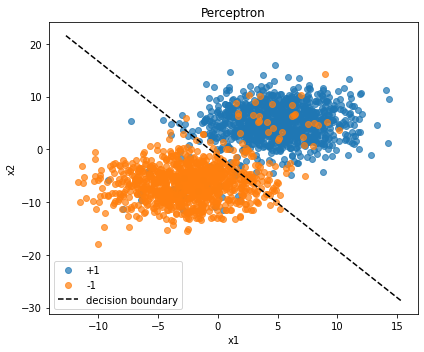

In [15]:
plt.figure(figsize = (6,5))
X_np = X.numpy()
y_np = y.numpy() # pyplot으로 나타내려면 numpy로 바꿔야
plt.scatter(X_np[y_np==1,0], X_np[y_np==1,1],c='tab:blue',label='+1',alpha=0.7)
plt.scatter(X_np[y_np==-1,0],X_np[y_np==-1,1],c='tab:orange',label='-1',alpha=0.7)
w = model.w.detach().numpy()
b = model.b.item()

if abs(w[1])> 1e-8: # w[1]이 0이 아닐때(안전장치)
    xs = np.linspace(X_np[:,0].min()-1, X_np[:,0].max()+1,200) # x축 좌표 만들기 : 데이터의 최소부터 최대까지 200개 구간으로 나눔
    ys = -(w[0]/w[1]) * xs - b / w[1]
    plt.plot(xs, ys, 'k--', label='decision boundary')
else:
    x_line = -b / (w[0] + 1e-12)
    plt.axvline(x_line, color='k', linestyle='--', label='decision boundary')

plt.title("Perceptron")
plt.xlabel('x1'); plt.ylabel('x2')
plt.legend()
plt.tight_layout()
plt.savefig("perceptron.jpg", bbox_inches='tight')
plt.show()